# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [263]:
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [264]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d

In [265]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [266]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [300]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [301]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [302]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [355]:
hyper_parameters = {
    "lgbm1__max_depth": [100, 500],
    "lgbm1__num_leaves": [200, 100],
    "lr__lr__C": [0.1],
    "rf__rf__n_estimators": [100],
    "breaks": all_breaks[:5]
}

In [356]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [357]:
lgbm = LGBMClassifier()
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("lr", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("rf", RandomForestClassifier())
])
base_clfs = {
    "lr": lr,
    "lgbm": LGBMClassifier(),
    "rf": rf
}

In [358]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [359]:
from src.models.classifiers import StackedGeneralizationClassifier

In [ ]:
sg = StackedGeneralizationClassifier(base_clfs = base_clfs, meta_clf = LogisticRegression(), verbose=False)

sg.cv_outer_loop(all_hyper_parameters = all_hyper_parameters, X = X_train, y = y_train, refit=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Outer loop:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop:
	Number of 0's: ~977 (94.18%)
	Number of 1's: ~60 (5.82%)


In [347]:
y_test_pred_con, y_test_pred_cut = sg.predict(X_test)

In [348]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out continous model: 0.9603804162401911'

In [349]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out continous model: 0.8911122483793927'

In [350]:
from src.visualization.visualize import plot_roc, plot_precision_recall

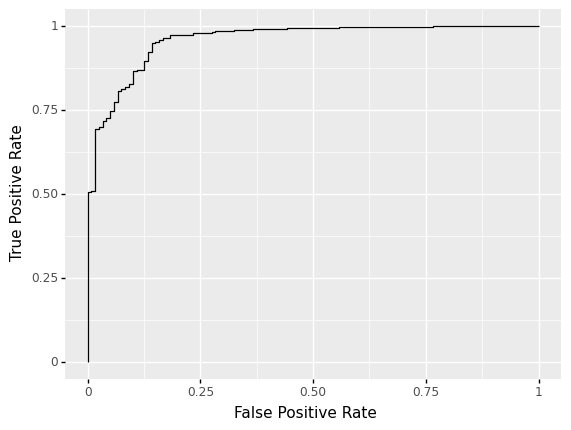

<ggplot: (332747446)>

In [351]:
plot_roc(y_test, y_test_pred_con)

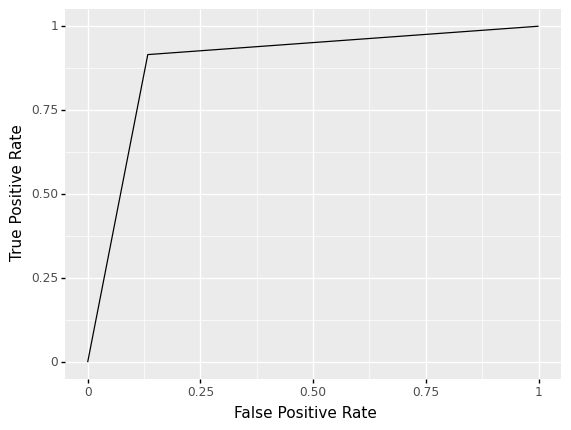

<ggplot: (331973308)>

In [352]:
plot_roc(y_test, y_test_pred_cut)

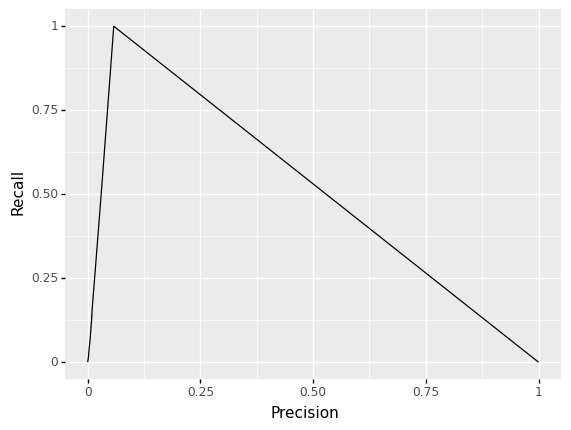

<ggplot: (396616861)>

In [353]:
plot_precision_recall(y_test, y_test_pred_con)